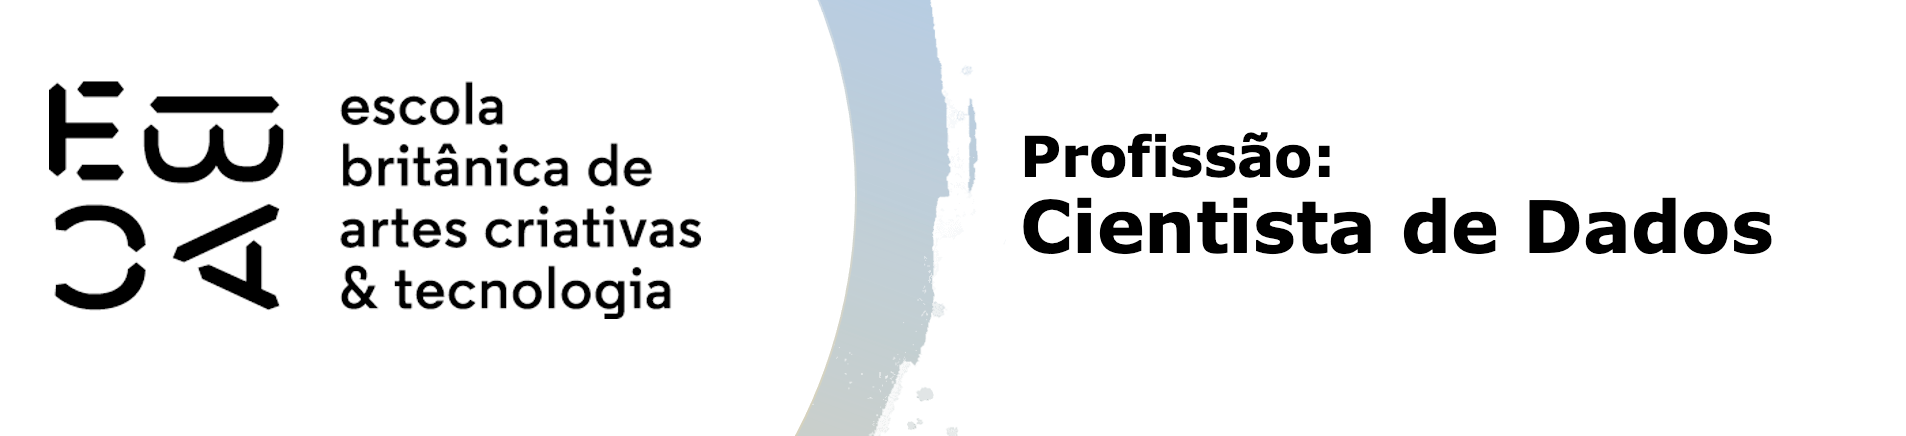

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [61]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import patsy

In [21]:
df = pd.read_feather('../credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [22]:
# Separando treino e teste
ultima_data = df.data_ref.max()
train = df[df['data_ref'] <= ultima_data - pd.DateOffset(months=3)].copy()
test  = df[df['data_ref'] > ultima_data - pd.DateOffset(months=3)].copy()

In [23]:
# Criando variável mês para os plots
train['mes'] = train.data_ref.dt.month_name(locale='Portuguese')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [24]:
train.data_ref.value_counts()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
Name: count, dtype: int64

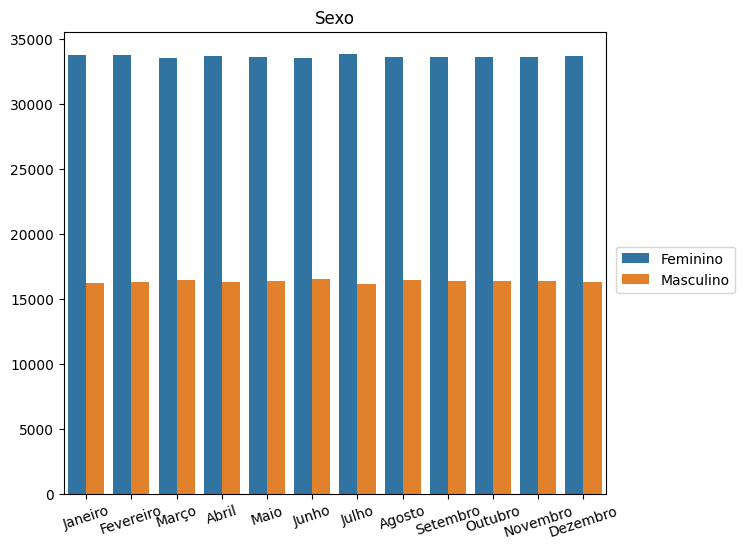

In [25]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x='mes', hue='sexo', data=train)
plt.title('Sexo')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=18)
plt.legend(['Feminino', 'Masculino'])
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.128, .55), ncol=1, title=None)
plt.show()

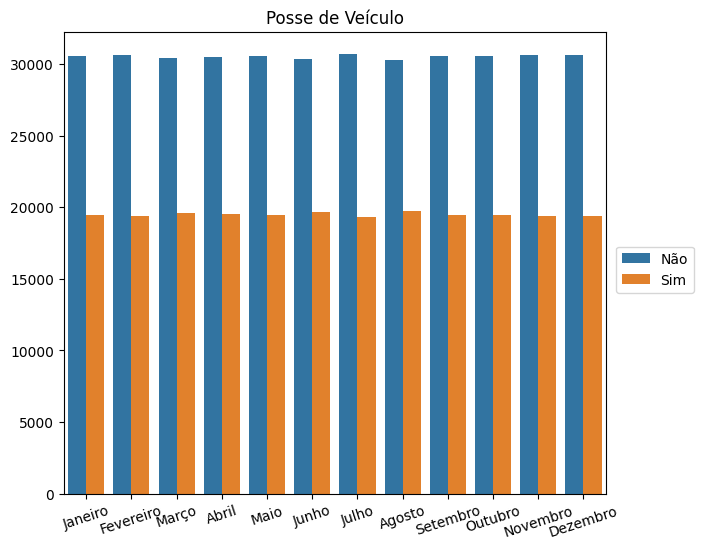

In [26]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x='mes', hue='posse_de_veiculo', data=train)
plt.title('Posse de Veículo')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=18)
plt.legend(['Não', 'Sim'])
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

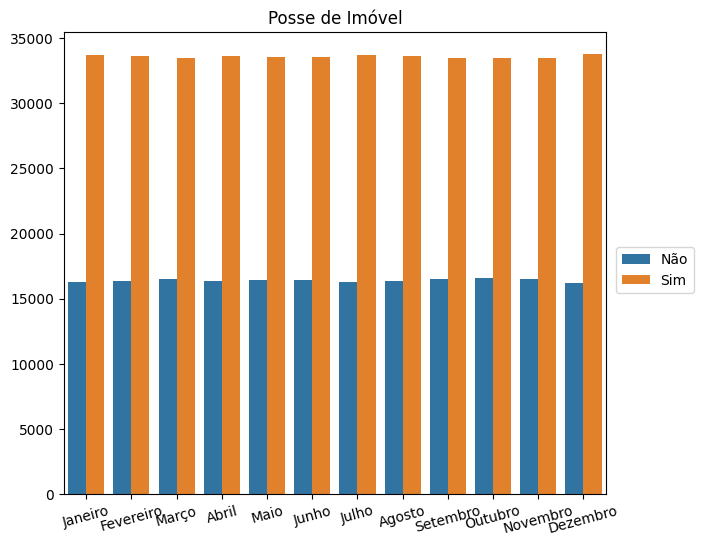

In [27]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x='mes', hue='posse_de_imovel', data=train)
plt.title('Posse de Imóvel')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
plt.legend(['Não', 'Sim'])
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

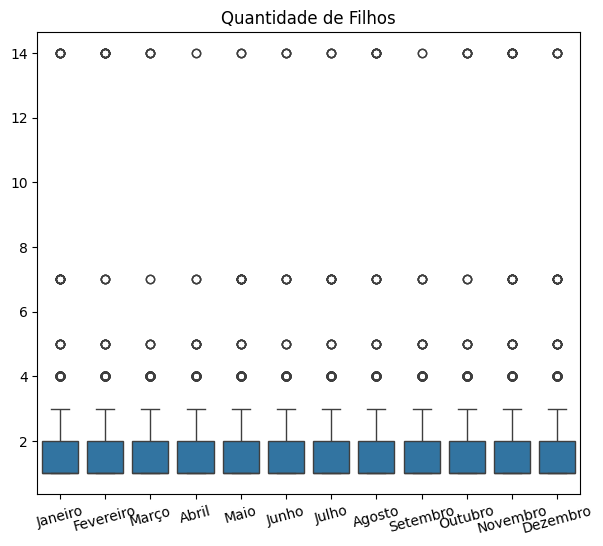

In [28]:
# Quantidade de filhos (qantidade maior que zero apenas) pelo tempo
plt.figure(figsize=(7,6))
ax = sns.boxplot(x=train.mes, y=train['qtd_filhos'][train['qtd_filhos']>0])
plt.title('Quantidade de Filhos')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
plt.show()

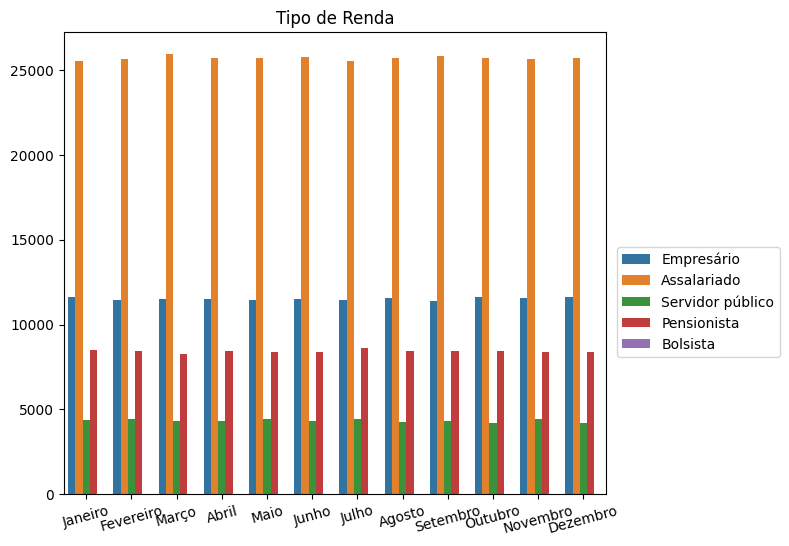

In [29]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x=train.mes, hue=train['tipo_renda'])
plt.title('Tipo de Renda')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.17, .55), ncol=1, title=None)
plt.show()

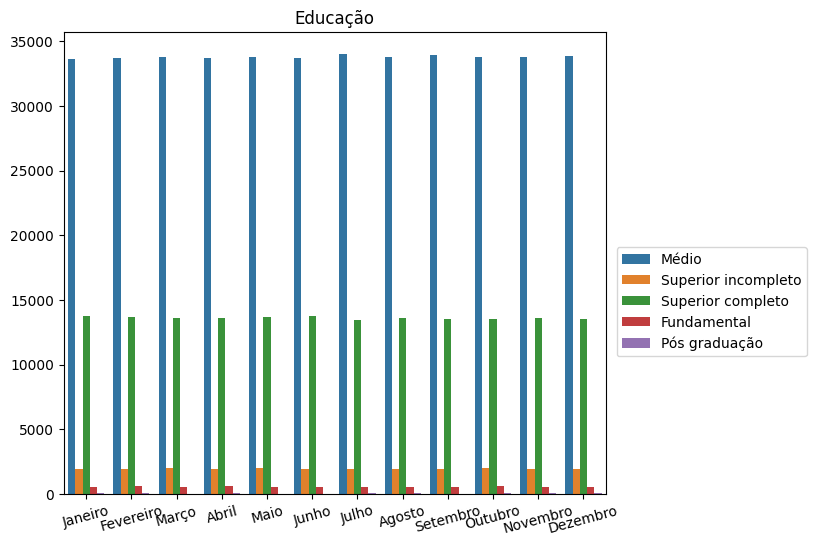

In [30]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x=train.mes, hue=train['educacao'])
plt.title('Educação')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.195, .55), ncol=1, title=None)
plt.show()

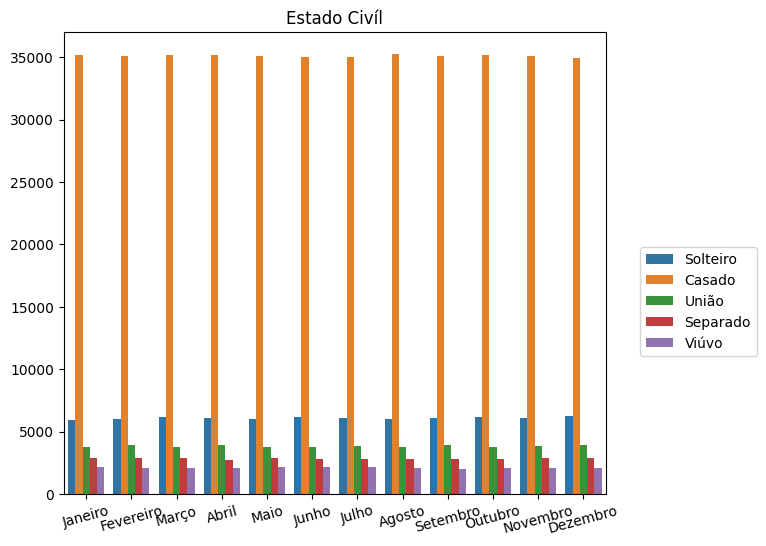

In [31]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x=train.mes, hue=train['estado_civil'])
plt.title('Estado Civíl')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.17, .55), ncol=1, title=None)
plt.show()

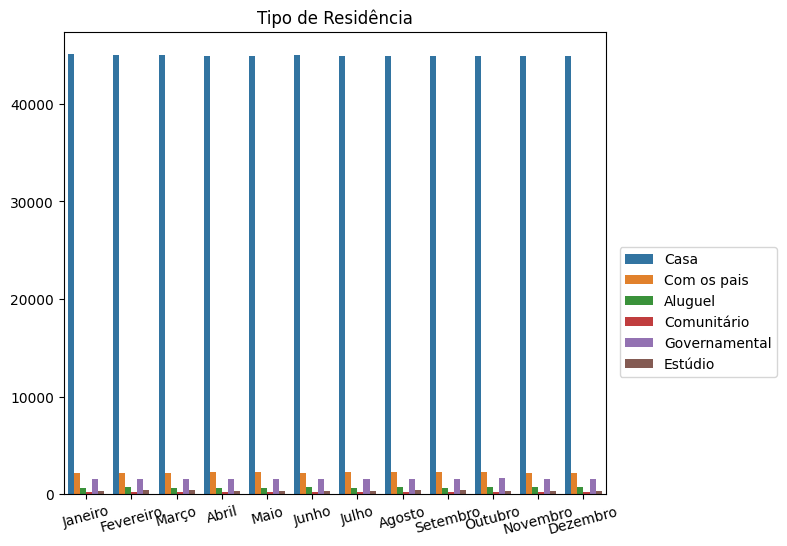

In [32]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x=train.mes, hue=train['tipo_residencia'])
plt.title('Tipo de Residência')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.17, .55), ncol=1, title=None)
plt.show()

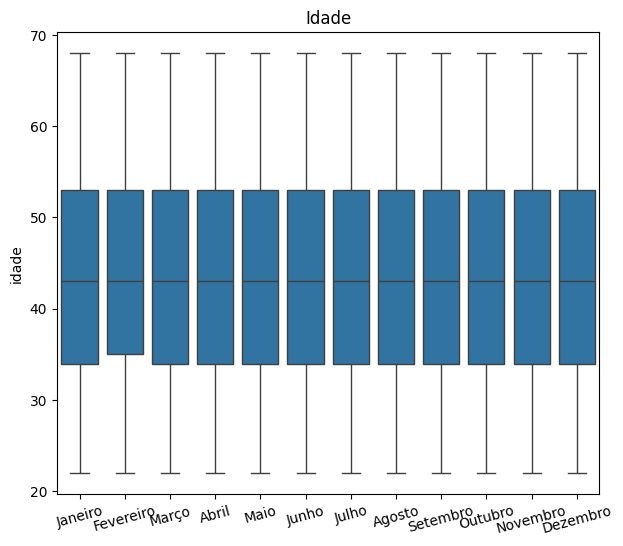

In [33]:
plt.figure(figsize=(7,6))
ax = sns.boxplot(x=train.mes, y=train['idade'])
plt.title('Idade')
plt.xlabel('')
plt.xticks(rotation=15)
plt.show()

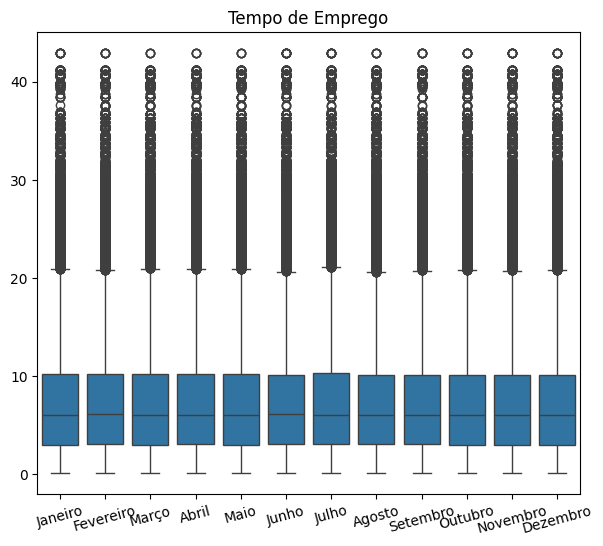

In [34]:
plt.figure(figsize=(7,6))
ax = sns.boxplot(x=train.mes, y=train['tempo_emprego'])
plt.title('Tempo de Emprego')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
plt.show()

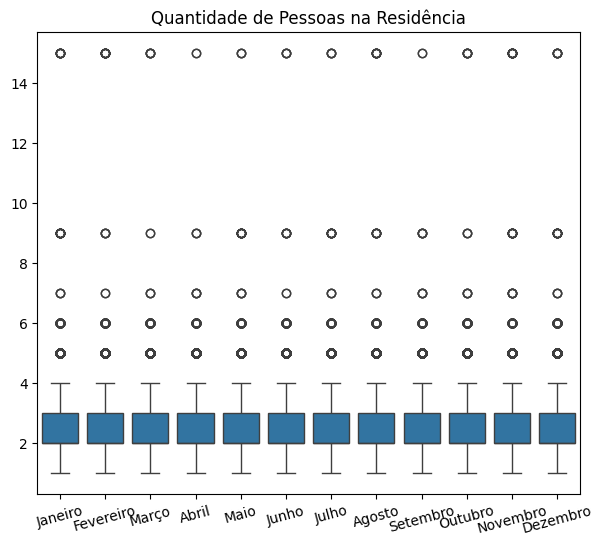

In [35]:
plt.figure(figsize=(7,6))
ax = sns.boxplot(x=train.mes, y=train['qt_pessoas_residencia'])
plt.title('Quantidade de Pessoas na Residência')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
plt.show()

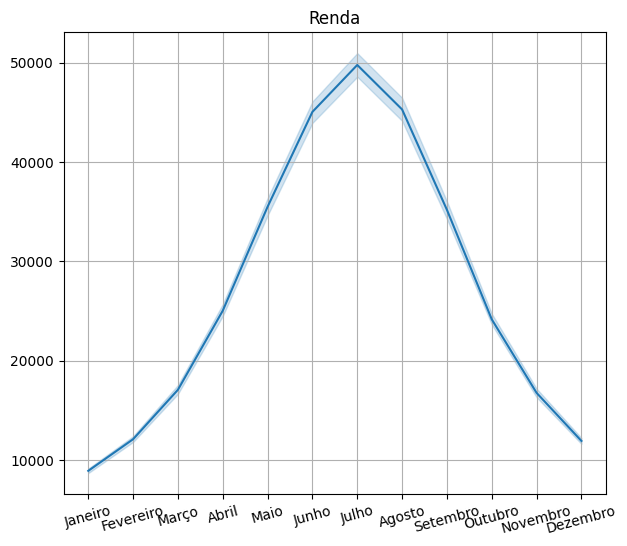

In [36]:
plt.figure(figsize=(7,6))
sns.lineplot(x=train.mes, y=train['renda'])
plt.title('Renda')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)
plt.grid()
plt.show()

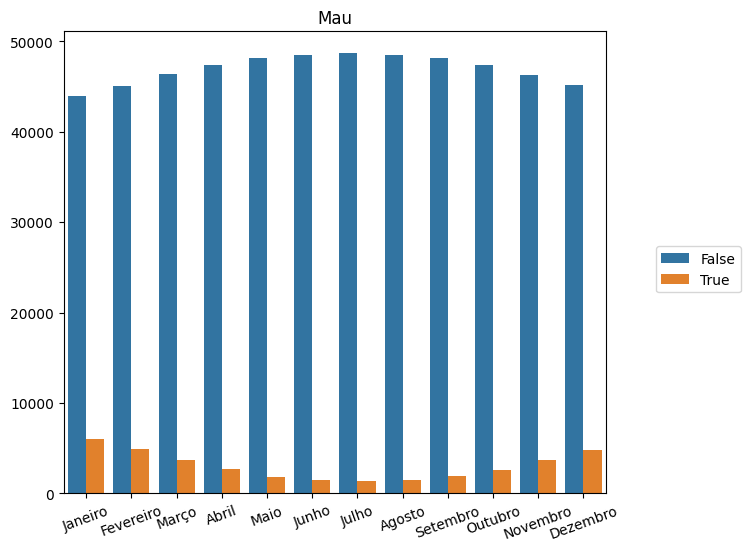

In [37]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x=train.mes, hue=train['mau'])
plt.title('Mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=20)
sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.17, .55), ncol=1, title=None)
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

<Figure size 700x600 with 0 Axes>

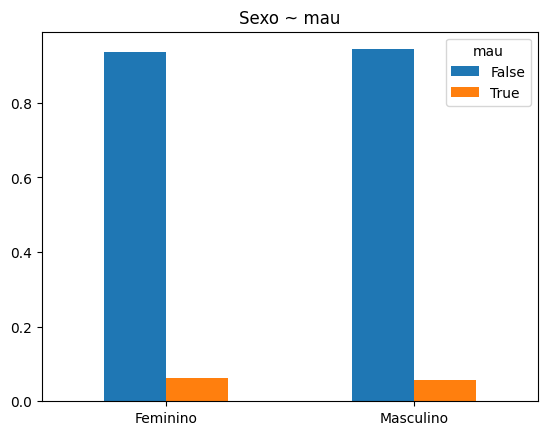

In [38]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='sexo', hue='mau', data=train)
freq = pd.crosstab(train['sexo'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Sexo ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)

plt.xticks(ticks=(0, 1), labels=['Feminino', 'Masculino'])

sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.128, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

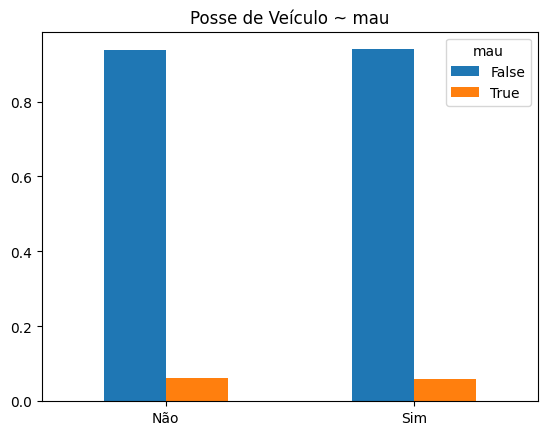

In [39]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='posse_de_veiculo', hue='mau', data=train)
freq = pd.crosstab(train['posse_de_veiculo'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Posse de Veículo ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)

plt.xticks(ticks=(0, 1), labels=['Não', 'Sim'])

sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.128, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

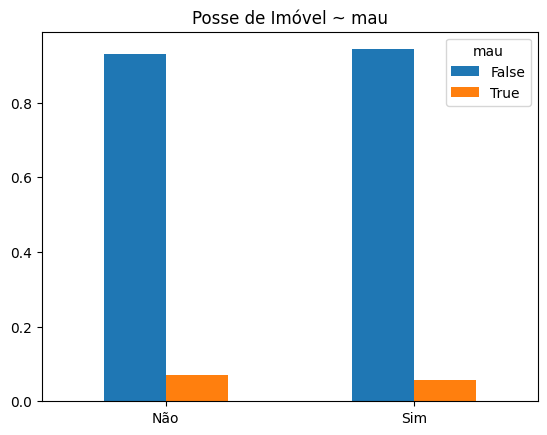

In [40]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='posse_de_imovel', hue='mau', data=train)
freq = pd.crosstab(train['posse_de_imovel'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Posse de Imóvel ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)

plt.xticks(ticks=(0, 1), labels=['Não', 'Sim'])

sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

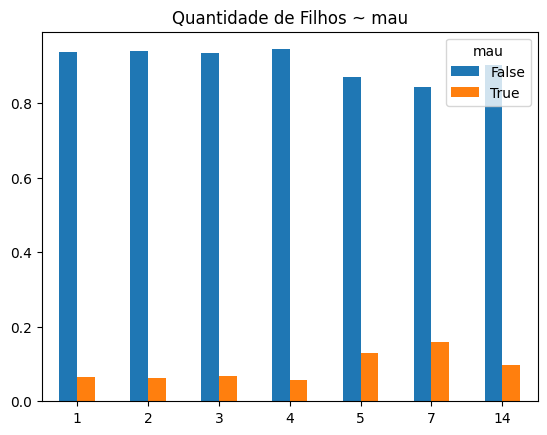

In [41]:
plt.figure(figsize=(7,6))

# ax = sns.boxplot(x=train['qtd_filhos'][train['qtd_filhos']>0], hue='mau', data=train)
freq = pd.crosstab(train['qtd_filhos'][train['qtd_filhos']>0], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Quantidade de Filhos ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)

sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

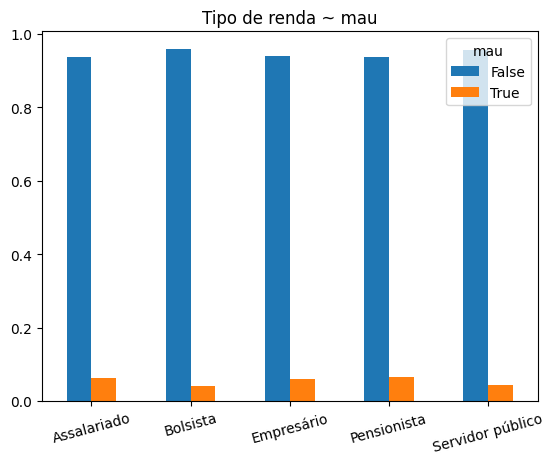

In [42]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='tipo_renda', hue='mau', data=train)
freq = pd.crosstab(train['tipo_renda'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Tipo de renda ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

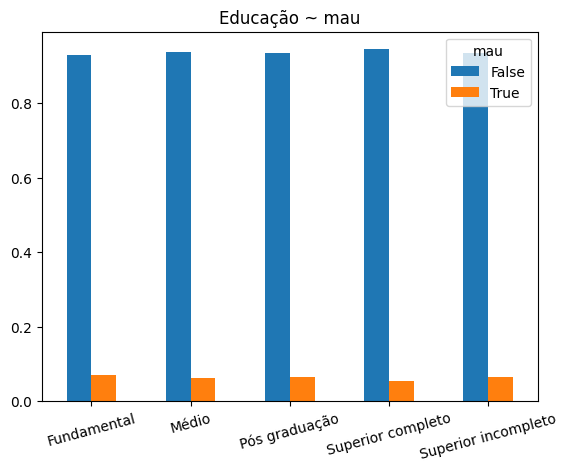

In [43]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='tipo_renda', hue='mau', data=train)
freq = pd.crosstab(train['educacao'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Educação ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

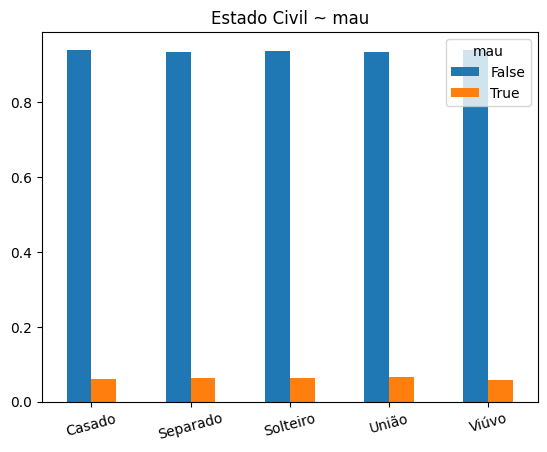

In [44]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='tipo_renda', hue='mau', data=train)
freq = pd.crosstab(train['estado_civil'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Estado Civil ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

<Figure size 700x600 with 0 Axes>

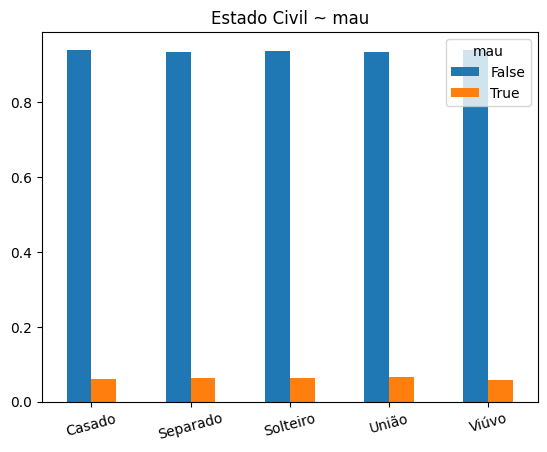

In [45]:
plt.figure(figsize=(7,6))

# ax = sns.countplot(x='tipo_renda', hue='mau', data=train)
freq = pd.crosstab(train['estado_civil'], train['mau'])
freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
freq_pctlin.plot.bar()

plt.title('Estado Civil ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.show()

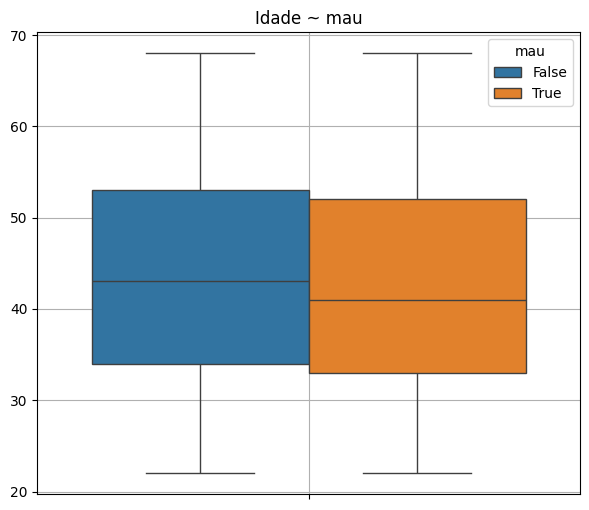

In [46]:
plt.figure(figsize=(7,6))

ax = sns.boxplot(y='idade', hue='mau', data=train)
# freq = pd.crosstab(train['idade'], train['mau'])
# freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
# freq_pctlin.plot.area()

plt.title('Idade ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.grid()
plt.show()

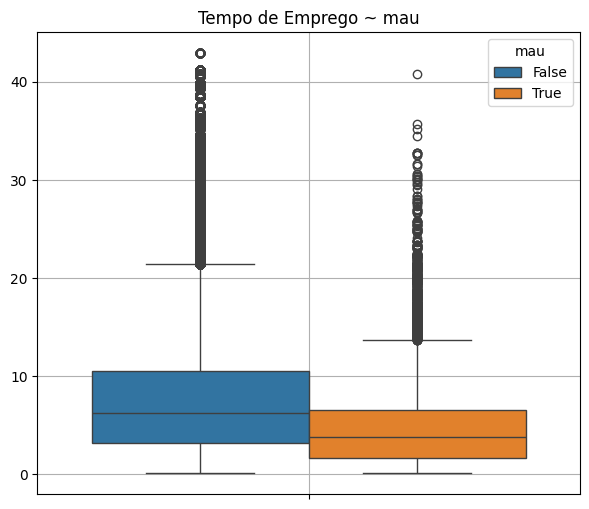

In [47]:
plt.figure(figsize=(7,6))

ax = sns.boxplot(y='tempo_emprego', hue='mau', data=train)
# freq = pd.crosstab(train['mau'], train['tempo_emprego'])
# freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
# freq_pctlin.plot.area()

plt.title('Tempo de Emprego ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.grid()
plt.show()

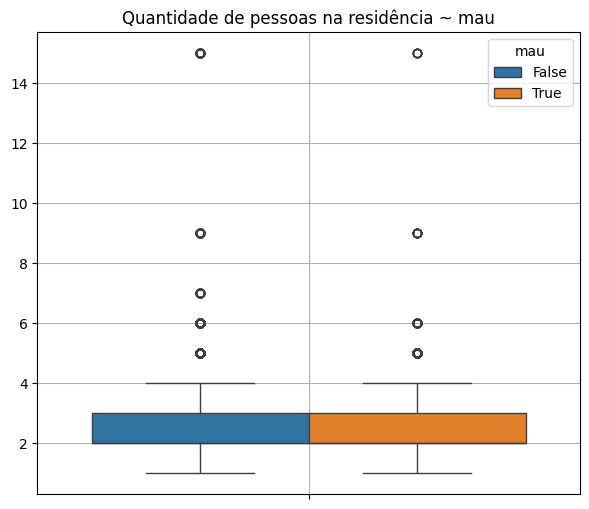

In [48]:
plt.figure(figsize=(7,6))

ax = sns.boxplot(y='qt_pessoas_residencia', hue='mau', data=train)
# freq = pd.crosstab(train['mau'], train['tempo_emprego'])
# freq_pctlin = freq.div(freq.sum(axis=1), axis=0)
# freq_pctlin.plot.area()

plt.title('Quantidade de pessoas na residência ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.grid()
plt.show()

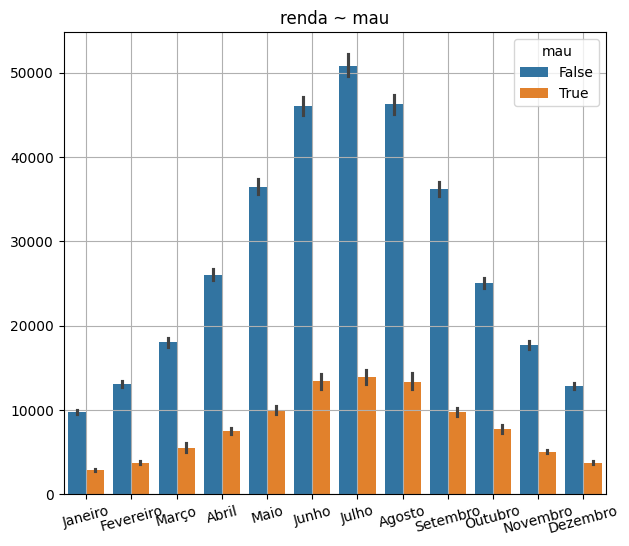

In [49]:
plt.figure(figsize=(7,6))

ax = sns.barplot(x='mes', y='renda', hue='mau', data=train)

plt.title('renda ~ mau')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15)

# sns.move_legend(ax, 'upper center', bbox_to_anchor=(1.09, .55), ncol=1, title=None)
plt.grid()
plt.show()

In [50]:
### Variáveis mais correlacionadas positiva ou negativamente com a variável "mau"
cm = pd.get_dummies(train.drop(['mes', 'data_ref'], axis=1),
                    drop_first=True).corr(method='spearman')
print(cm[['mau']].abs().sort_values(by='mau', ascending=False))

                                    mau
mau                            1.000000
renda                          0.224072
tempo_emprego                  0.129574
idade                          0.026757
posse_de_imovel_S              0.023911
tipo_renda_Servidor público    0.020897
educacao_Superior completo     0.014001
tipo_residencia_Com os pais    0.012298
sexo_M                         0.012254
tipo_residencia_Casa           0.011293
educacao_Médio                 0.011130
index                          0.008822
qtd_filhos                     0.007364
estado_civil_União             0.006379
tipo_renda_Pensionista         0.006024
tipo_renda_Empresário          0.003811
estado_civil_Solteiro          0.003493
qt_pessoas_residencia          0.003307
estado_civil_Separado          0.003185
tipo_residencia_Estúdio        0.003084
educacao_Superior incompleto   0.003018
tipo_residencia_Comunitário    0.002541
estado_civil_Viúvo             0.002187
posse_de_veiculo_S             0.002068


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [52]:
train.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
mes                           0
dtype: int64

In [53]:
# Substituindo valores faltantes pela média
train['tempo_emprego'] = train['tempo_emprego'].fillna(train['tempo_emprego'].mean())

In [54]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')
    evento = tab.columns[1]
    nao_evento = tab.columns[0]
    tab['pct_evento'] = tab[evento]/tab.loc['total', evento]
    tab['pct_nao_evento'] = tab[nao_evento]/tab.loc['total', nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [55]:
variaveis = ['renda', 'tempo_emprego', 'idade', 'posse_de_imovel', 'tipo_renda', 'educacao']

metadados = pd.DataFrame({'dtype':train[variaveis].dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['mau', 'papel'] = 'resposta'
metadados.loc['data_ref', 'papel'] = 'controle'
metadados['nunique'] = train[metadados.index].nunique()

In [58]:
for var in metadados[metadados.papel=='covariavel'].index:
    ### Criando quantis para variaveis com mais do que 30 categorias
    if (metadados.loc[var, 'nunique'] > 30):
        metadados.loc[var, 'IV'] = IV(pd.qcut(train[var], 10, duplicates='drop'), train.mau)
    else:
        metadados.loc[var, 'IV'] = IV(train[var], train.mau)

    ### Categorizando valores do Information Value
    if metadados.loc[var, 'IV'] < 0.02:
        metadados.loc[var, 'poder_preditivo'] = 'Inútil'
    if (metadados.loc[var, 'IV'] >= 0.02) & (metadados.loc[var, 'IV'] < 0.1):
        metadados.loc[var, 'poder_preditivo'] = 'Fraco'
    if (metadados.loc[var, 'IV'] >= 0.1) & (metadados.loc[var, 'IV'] < 0.3):
        metadados.loc[var, 'poder_preditivo'] = 'Médio'
    if (metadados.loc[var, 'IV'] >= 0.3) & (metadados.loc[var, 'IV'] < 0.5):
        metadados.loc[var, 'poder_preditivo'] = 'Forte'
    if metadados.loc[var, 'IV'] > 0.5:
        metadados.loc[var, 'poder_preditivo'] = 'Suspeito'

metadados.sort_values('IV', ascending=False)

,dtype,papel,nunique,IV,poder_preditivo
renda,float64,covariavel,112472,1.056866,Suspeito
tempo_emprego,float64,covariavel,3005,0.319819,Forte
idade,int64,covariavel,47,0.020839,Fraco
tipo_renda,object,covariavel,5,0.009718,Inútil
posse_de_imovel,object,covariavel,2,0.009690,Inútil
educacao,object,covariavel,5,0.003690,Inútil
mau,NaN,resposta,2,NaN,nan
data_ref,NaN,controle,12,NaN,nan


In [62]:
train['mau'] = train.mau.astype('int')
train['tempo_emprego_quantil'], tempo_emprego_bins = pd.qcut(train['tempo_emprego'], 10, duplicates='drop', retbins = True)
# train['idade_quantil'] = pd.qcut(train['idade'], 10, duplicates='drop')
train['renda_quantil'], renda_bins = pd.qcut(train['renda'], 10, duplicates='drop', retbins = True)

formula = patsy.dmatrices('mau ~ tempo_emprego_quantil + renda_quantil', train)

res = smf.logit(formula, data=train).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.202191
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599981
Method:                           MLE   Df Model:                           18
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.1206
Time:                        13:44:39   Log-Likelihood:            -1.2131e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.2373      0.015    -82.893      0.000      -1.267      -1.208
tempo_emprego_quantil[T.Interval(1.458, 2.912, closed='right')]      -0.0526      0.020     -2.645      0.008      -0.092      -0.014
tempo_emprego_quantil[T.Interval(2.912, 4.301, closed='right')]      -0.0340      0.021     -1.660      0.097      -0.074       0.006
tempo_emprego_quantil[T.Interval(4.301, 5.759, closed='right')]      -0.0431      0.021     -2.011      0.044      -0.085      -0.001
tempo_emprego_quantil[T.Interval(5.759, 7.474, closed='right')]      -0.0892      0.023     -3.846      0.000      -0.135      -0.044
tempo_emprego_quantil[T.Interval(7.474, 7.748, closed='right')]      -0.0737      0.019     -3.905      0.000      -0.111      -0.037
tempo_emprego_quantil[T.Interval(7.748, 8.107, closed='right')]      -0.0785      0.047     -1.658      0.097      -0.171       0.014
tempo_emprego_quantil[T.Interval(8.107, 10.436, closed='right')]     -0.0729      0.025     -2.905      0.004      -0.122      -0.024
tempo_emprego_quantil[T.Interval(10.436, 15.219, closed='right')]    -0.1097      0.031     -3.592      0.000      -0.170      -0.050
tempo_emprego_quantil[T.Interval(15.219, 42.907, closed='right')]    -0.1967      0.049     -4.041      0.000      -0.292      -0.101
renda_quantil[T.Interval(2450.919, 3905.11, closed='right')]         -0.7797      0.016    -47.598      0.000      -0.812      -0.748
renda_quantil[T.Interval(3905.11, 5513.49, closed='right')]          -1.1550      0.018    -63.350      0.000      -1.191      -1.119
renda_quantil[T.Interval(5513.49, 7430.69, closed='right')]          -1.4756      0.020    -72.885      0.000      -1.515      -1.436
renda_quantil[T.Interval(7430.69, 9887.58, closed='right')]          -1.7308      0.022    -77.868      0.000      -1.774      -1.687
renda_quantil[T.Interval(9887.58, 13152.38, closed='right')]         -2.0114      0.025    -81.130      0.000      -2.060      -1.963
renda_quantil[T.Interval(13152.38, 18064.01, closed='right')]        -2.3069      0.028    -82.193      0.000      -2.362      -2.252
renda_quantil[T.Interval(18064.01, 26666.57, closed='right')]        -2.6495      0.033    -80.944      0.000      -2.714      -2.585
renda_quantil[T.Interval(26666.57, 49048.516, closed='right')]       -3.0745      0.040    -76.037      0.000      -3.154      -2.995
renda_quantil[T.Interval(49048.516, 4083986.22, closed='right')]     -4.0500      0.069    -58.416      0.000      -4.186      -3.914
=====================================================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [63]:
### Métricas na base de treino

pred = res.predict()

threshold = .085
preds = (pred >= threshold).astype(int)

acc = accuracy_score(train.mau, preds)
print("Acurácia:", acc)

df_results = pd.DataFrame({'probabilidade': pred, 'target':train.mau}).sort_values(by='probabilidade', ascending=False)

df_results['cumsum_pos'] = df_results['target'].cumsum()
df_results['cumsum_neg'] = (1 - df_results['target']).cumsum()
df_results['percent_pos'] = df_results['cumsum_pos'] / df_results['target'].sum()
df_results['percent_neg'] = df_results['cumsum_neg'] / (len(train.mau) - df_results['target'].sum())

df_results['ks'] = df_results['percent_pos'] - df_results['percent_neg']
ks = df_results['ks'].max()
print("KS      :", ks)

auc = roc_auc_score(train.mau, preds)
print("AUC     :", auc)

gini = 2 * auc - 1
print("Gini    :", gini)

Acurácia: 0.80492
KS      : 0.3952469249622486
AUC     : 0.6812260148865537
Gini    : 0.3624520297731073


In [64]:
### Rodando modelo na base de teste e extraindo métricas

### Preparando base de teste
test['tempo_emprego'] = test['tempo_emprego'].fillna(test['tempo_emprego'].mean())
test['mau'] = test.mau.astype('int')
test['tempo_emprego_quantil'] = pd.cut(test['tempo_emprego'], duplicates='drop', bins=tempo_emprego_bins, include_lowest=True)
test['renda_quantil'] = pd.cut(test['renda'], duplicates='drop', bins=renda_bins, include_lowest=True)

test_pred = res.predict(test[['tempo_emprego_quantil', 'renda_quantil']])

test_preds = (test_pred >= threshold).astype(int)

acc = accuracy_score(test.mau, test_preds)
print("Acurácia:", acc)

df_results = pd.DataFrame({'probabilidade': test_pred, 'target':test.mau}).sort_values(by='probabilidade', ascending=False)
df_results['cumsum_pos'] = df_results['target'].cumsum()
df_results['cumsum_neg'] = (1 - df_results['target']).cumsum()
df_results['percent_pos'] = df_results['cumsum_pos'] / df_results['target'].sum()
df_results['percent_neg'] = df_results['cumsum_neg'] / (len(test.mau) - df_results['target'].sum())

df_results['ks'] = df_results['percent_pos'] - df_results['percent_neg']
ks = df_results['ks'].max()
print("KS      :", ks)

auc = roc_auc_score(test.mau, test_preds)
print("AUC     :", auc)

gini = 2 * auc - 1
print("Gini    :", gini)

Acurácia: 0.4937666666666667
KS      : 0.34161860795454546
AUC     : 0.6484779829545455
Gini    : 0.296955965909091


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [65]:
train = df[df['data_ref'] <= ultima_data - pd.DateOffset(months=3)].copy()
test  = df[df['data_ref']  > ultima_data - pd.DateOffset(months=3)].copy()

In [66]:
X_train = train.drop(['data_ref', 'index', 'mau'], axis=1)
y_train = train.mau

### Objetivos do preprocessamento:
- Substituir valores missing pela média.
- Aplicar quantização nas variaveis que possuem mais de 10 valores únicos.
- Aplicar o _one-hot-encoding_ nas variáveis categóricas.

In [67]:
class PreProcessamento(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_features = None
        self.cat_features = None
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        self.discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

    def fit(self, X, y=None):
        self.num_features = X.select_dtypes(include=['number']).columns.tolist()
        self.cat_features = X.select_dtypes(include=['object']).columns.tolist()
        
        return self

    def transform(self, X):
        # Imputando a média nos valores faltantes das variáveis numéricas
        num_imputer = SimpleImputer(strategy='mean')
        X[self.num_features] = num_imputer.fit_transform(X[self.num_features])

        # Filtrando variáveis numéricas que possuem valores únicos maiores que 10
        num_features_filtered = [col for col in self.num_features if X[col].nunique() > 10]

        # Quantizando variáveis filtradas
        if num_features_filtered:
            X[num_features_filtered] = self.discretizer.fit_transform(X[num_features_filtered])

        # Aplicando one-hot-encoding nas variáveis categóricas
        if self.cat_features:
            encoded_cat = self.encoder.fit_transform(X[self.cat_features]).toarray()
            encoded_cat_df = pd.DataFrame(encoded_cat, columns=self.encoder.get_feature_names_out(self.cat_features))
            X = X.drop(columns=self.cat_features).reset_index(drop=True)
            X = pd.concat([X, encoded_cat_df], axis=1)
        
        return X

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [68]:
def IV_feature_selection(X):
    ivs = {}
    for col in X.columns.tolist():
        ivs[col] = IV(X[col], y_train)
    return X[[_[0] for _ in sorted(ivs.items(), key=lambda x:x[1], reverse=True) if _[1] < 1][:10]]

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [69]:
pca = PCA(n_components=5, random_state=27)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [79]:
pipeline = Pipeline([
    ('preprocessor', PreProcessamento()),
    ('feature_selection', FunctionTransformer(IV_feature_selection)),
    ('PCA', pca),
    ('classifier', LogisticRegression())
])
np.seterr(divide = 'ignore');

### Treinar um modelo de regressão logistica com o resultado

In [80]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PreProcessamento()),
                ('feature_selection',
                 FunctionTransformer(func=<function IV_feature_selection at 0x0000029947363100>)),
                ('PCA', PCA(n_components=5, random_state=27)),
                ('classifier', LogisticRegression())])

### Salvar o pickle file do modelo treinado

In [83]:
import joblib

nome_arquivo = 'model_final.pkl'
joblib.dump(pipeline, nome_arquivo)

['model_final.pkl']

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [85]:
df = pd.read_feather('../credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [86]:
from pycaret.classification import *

In [87]:
dataset = df.sample(30000)

In [88]:
dataset.drop(['index', 'data_ref'], axis=1, inplace=True)

In [89]:
data = dataset.sample(frac=0.95, random_state=9)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print(f'Conjunto de dados para modelagem (treino e teste): {data.shape}')
print(f'Conjunto de dados usado apenas como validação: {data_unseen.shape}')

Conjunto de dados para modelagem (treino e teste): (28500, 13)
Conjunto de dados usado apenas como validação: (1500, 13)


In [90]:
data['qtd_filhos'] = data.qtd_filhos.astype(float)

In [91]:
exp_1 = setup(data=data, target='mau',
              experiment_name='credit_1',
              normalize=True,
              normalize_method='zscore',
              transformation=True,
              transformation_method='quantile',
              fix_imbalance=True,
              remove_multicollinearity=True)

,Description,Value
0,Session id,4811
1,Target,mau
2,Target type,Binary
3,Original data shape,"(28500, 13)"
4,Transformed data shape,"(45368, 30)"
5,Transformed train set shape,"(36818, 30)"
6,Transformed test set shape,"(8550, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.1%


In [92]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9198,0.7781,0.0649,0.3846,0.1111,0.0908,0.1324
1,0.9213,0.7683,0.0519,0.4211,0.0925,0.0768,0.1263
2,0.9258,0.7702,0.0844,0.6500,0.1494,0.1341,0.2160
3,0.9213,0.7644,0.0519,0.4211,0.0925,0.0768,0.1263
4,0.9253,0.7667,0.0649,0.6667,0.1183,0.1061,0.1922
5,0.9203,0.7629,0.0714,0.4074,0.1215,0.1008,0.1449
6,0.9183,0.7637,0.0519,0.3200,0.0894,0.0693,0.1025
7,0.9173,0.7751,0.0519,0.2963,0.0884,0.0669,0.0962
8,0.9248,0.7741,0.0909,0.5833,0.1573,0.1394,0.2093


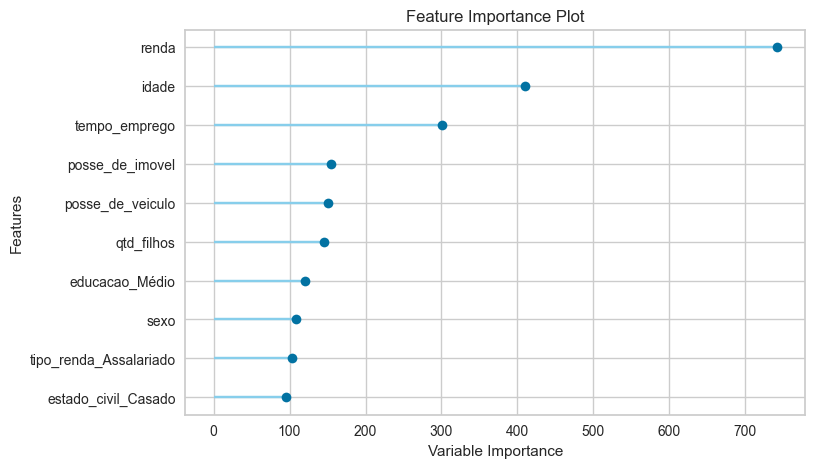

In [94]:
plot_model(lightgbm, plot='feature')

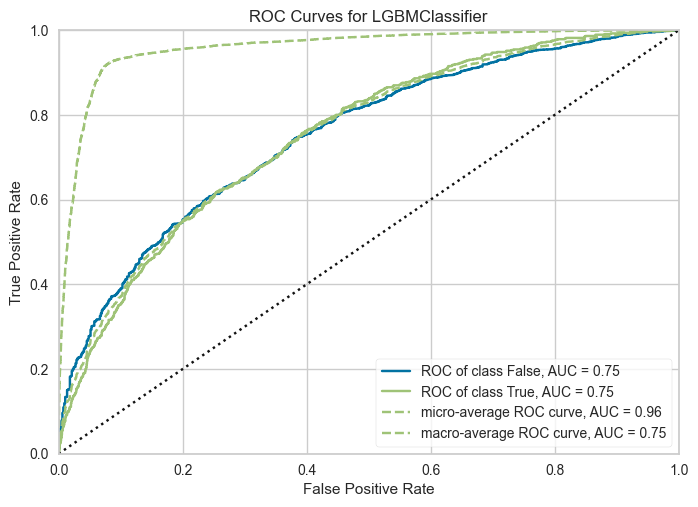

In [95]:
plot_model(lightgbm, plot='auc')

### Salvar o arquivo do modelo treinado

In [99]:
save_model(lightgbm, 'lightgbm_112024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.